In [1]:
import numpy as np
from numpy import pi as π
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import firedrake
from firedrake import Constant, inner, sqrt, tr, grad, div, as_vector, exp,sym, as_vector, dx, ds, Mesh, Function, project, TransferManager
import meshpy, meshpy.geometry, meshpy.triangle
import irksome
from irksome import Dt
from scipy.signal import detrend
import copy
import matplotlib
import irksome
from irksome import Dt
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle as pkl


# %matplotlib widget

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [180]:
# Constants
spy = 365.25 * 24 * 60 * 60
ρ = Constant(917.0)    # kg / m^3
c = Constant(2180)     # J / kg C
k = Constant(2.22)  # W / m C
α = (k/(ρ*c)) # diffusivity
A = 3.5e-25 
n = 3
R = 8.31446261815324
act_vol = -1.74e-5
Q = 6e4 # activatyion energy J/mol

dTdz = 2e-2 #C per 100m
geo_flux = Constant(46e-3) #W/m^2

λ = Constant(10.0)    # m
grav = Constant(-9.81) #m/s^2

vel_mpy = Constant(0.50) #m/yr
vel = vel_mpy / spy



def ε(u):
    return sym(grad(u))

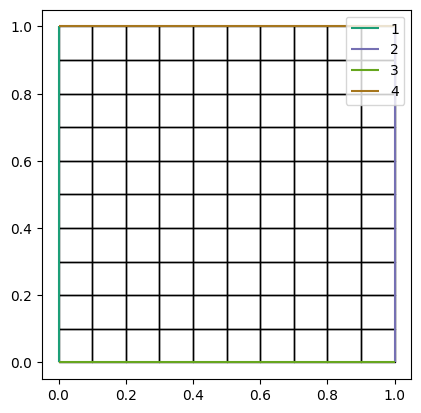

In [181]:
#Creating the initial mesh dimensions

nx, nz = 10, 10
initial_mesh = firedrake.UnitSquareMesh(nx, nz, quadrilateral=True)

fig, ax = plt.subplots()
ax.set_aspect("equal")
firedrake.triplot(initial_mesh, axes=ax)
ax.legend();

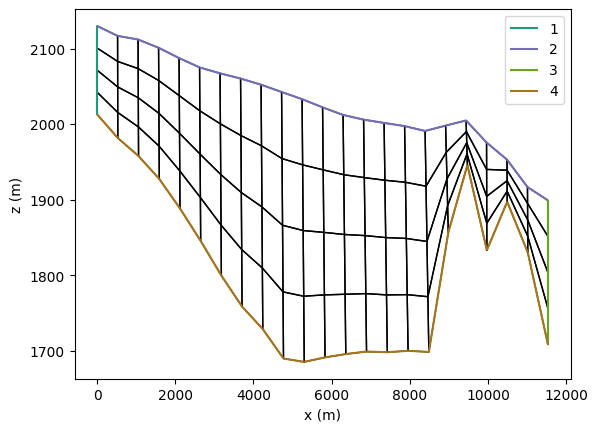

In [182]:
x, z = firedrake.SpatialCoordinate(initial_mesh)
mesh = Mesh('Current_meshes/ALHIC1902_low_res_minimum.msh')
# Input the mesh dimensions here, not sure how to do this automatically
right_boundary_heights = []

for i in mesh.coordinates.dat.data:
    if i[0] == np.max(mesh.coordinates.dat.data[:,0]):
        right_boundary_heights.append(i[1])

depth = np.max(right_boundary_heights) - np.min(right_boundary_heights)

# length = 24000

# slope = (height_max - height_min) / length


x, z = firedrake.SpatialCoordinate(mesh)

bed_id = [4]
left_id = [1]
surface_id = [2]
right_id = [3]

fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
firedrake.triplot(mesh, axes=ax)
# ax.set_ylim([-100,100])
# ax.set_xlim([0,500])
ax.set_aspect("auto")
ax.legend();

In [183]:
element = firedrake.FiniteElement("CG", "quadrilateral", 1)
V = firedrake.FunctionSpace(mesh, element)

T = firedrake.Function(V)
ϕ = firedrake.TestFunction(V)

In [184]:
pressure_space = firedrake.FunctionSpace(mesh, "CG", 1)
velocity_space = firedrake.VectorFunctionSpace(mesh, "CG", 2)
Y = velocity_space * pressure_space

y = firedrake.Function(Y)
u, p = firedrake.split(y)


μ = Constant(5e15) #Ice
# μ = Constant(1e14) #Test


v, q = firedrake.TestFunctions(y.function_space())

τ = 2 * μ * ε(u)
g = as_vector((0, grav))
f =  ρ * g

F_momentum = (inner(τ, ε(v)) - q * div(u) - p * div(v) - inner(f, v)) * dx

### Boundary conditions for flow

In [185]:
temperature_expr = T_mean - (z - 2000)*.01

In [186]:
w_s_divide = -0.05 / spy

divide_heights = []
for i in mesh.coordinates.dat.data:
    if i[0] == 0:
        divide_heights.append(i[1])

divide_depth = np.max(divide_heights) - np.min(divide_heights)

w_divide = w_s_divide * (((z - np.min(divide_heights)) / divide_depth))

In [187]:
w_s_abl = 0.02 / spy

abl_boundary_heights = []

for i in mesh.coordinates.dat.data:
    if i[0] == np.max(mesh.coordinates.dat.data[:,0]):
        abl_boundary_heights.append(i[1])


abl_depth = np.max(abl_boundary_heights) - np.min(abl_boundary_heights)

w_abl = w_s_abl * (((z - np.min(abl_boundary_heights)) / abl_depth))

In [188]:
bc_l = firedrake.DirichletBC(Y.sub(0), as_vector((0, w_divide)), left_id)
bc_r = firedrake.DirichletBC(Y.sub(0), as_vector((0, w_abl)), right_id)
bc_b = firedrake.DirichletBC(Y.sub(0), as_vector((0, 0)), bed_id) 

bc_stokes=[bc_l, bc_b, bc_r]

### Stokes solve

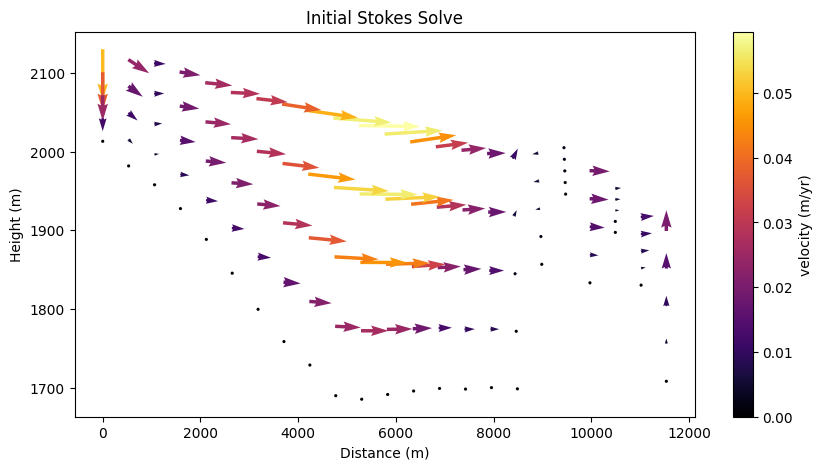

In [189]:
basis = firedrake.VectorSpaceBasis(constant=True, comm=firedrake.COMM_WORLD)
nullspace = firedrake.MixedVectorSpaceBasis(Y, [Y.sub(0), basis])

stokes_problem = firedrake.NonlinearVariationalProblem(F_momentum, y, bc_stokes)
parameters = {
    "nullspace": nullspace,
    "solver_parameters": {
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
}
stokes_solver = firedrake.NonlinearVariationalSolver(stokes_problem, **parameters)

stokes_solver.solve()

fig, axes = plt.subplots(figsize = [10,5])
vel_field_plot = firedrake.quiver(y.sub(0)*spy, axes=axes, cmap="inferno", scale=.6);
fig.colorbar(vel_field_plot, label='velocity (m/yr)')
axes.set_ylabel('Height (m)')
axes.set_xlabel('Distance (m)')
axes.set_title('Initial Stokes Solve')
# axes.set_xlim([8100,9750])
# axes.set_ylim([1700,1800])
plt.show()
# fig.savefig('Test_model_flowfield.png')

### Boundary conditions for temperature

In [212]:
# Surface condition
T_mean = -34 #average temp (C)
T_surface = Constant(T_mean) #

In [214]:
temperature_expr = T_mean - (z - 2000)*.01
top_temp_bc = firedrake.DirichletBC(V, temperature_expr, surface_id)
bcs_temp = [top_temp_bc]

### Temp solve

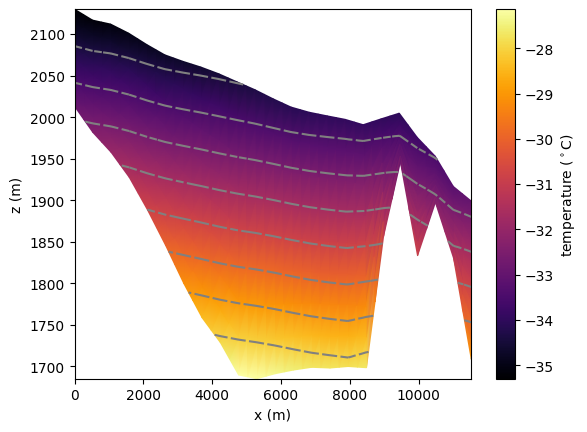

In [215]:
geothermal_flux = -geo_flux*ϕ  * ds((bed_id[0]))

F_diffusion = k * inner(grad(T), grad(ϕ)) * dx
F_advection = - ρ * c * T * inner(u, grad(ϕ)) * dx

F_0 = F_advection + F_diffusion + geothermal_flux

firedrake.solve(F_0 == 0, T, bcs_temp)

fig, ax = plt.subplots()
ax.set_aspect("auto")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
colors = firedrake.tripcolor(T, cmap="inferno", axes=ax)
fig.colorbar(colors, label="temperature (${}^\circ$C)")
levels = np.linspace(T.dat.data.min(), T.dat.data.max(), 10)
firedrake.tricontour(T, levels=levels, colors="grey", axes=ax);
# ax.set_xlim([9000,10000]);

### Time dependent solver

In [221]:
import irksome
from irksome import Dt

δx = mesh.cell_sizes.dat.data_ro[:].min()
umax = y.sub(0).dat.data_ro[:].max()
δt = Constant(10*spy)


F = ρ * c * Dt(T) * ϕ * dx + F_advection + F_diffusion + geothermal_flux 

temperature_expr_stepper = T_surface - (z - 2000)*.01
top_temp_stepper = firedrake.DirichletBC(V, temperature_expr_stepper, surface_id)
bcs_temp = [top_temp_stepper]

method = irksome.BackwardEuler()
temperature_solver = irksome.TimeStepper(F, method, Constant(0.0), δt, T, bcs=bcs_temp)

### Surface temp to model

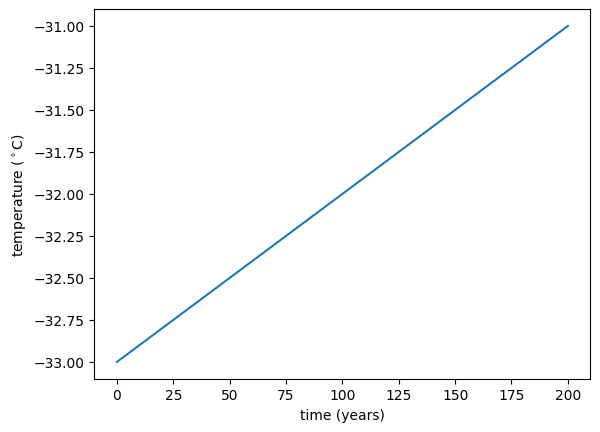

In [226]:
δT = 25.0
θ = 1 * π / 2
year = spy
years = 200
final_time = years * spy # years modeling * spy

freq = 1 # 1 for annual cycle
num_steps = int(final_time / float(δt))
T_mean_test = -34
mag_warming = 2
# def surface_temperature(t):
#     return T_mean + δT * np.sin(2 * π *freq* t / year + θ) + (t/final_time)*1

def surface_temperature(t):
    return -33  + (t/final_time)*mag_warming
    
ts = np.linspace(0.0, final_time, num_steps + 1)

surface_temps = surface_temperature(ts)

fig, ax = plt.subplots()
ax.set_xlabel("time (years)")
ax.set_ylabel("temperature (${}^\circ$C)")
ax.plot(ts / spy, surface_temps);

### Time loop

In [227]:
import tqdm
final_time = years* spy 
num_steps = int(final_time / float(δt))
Ts = [T.copy(deepcopy=True)]
ys = [y.copy(deepcopy=True)]

for step in tqdm.trange(num_steps):
    t = ts[step]
    T_surface.assign(surface_temperature(t))

    temperature_solver.advance()
    stokes_solver.solve()

    Ts.append(T.copy(deepcopy=True))
    ys.append(y.copy(deepcopy=True))

100%|███████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 67.10it/s]


### Plot the final timestep

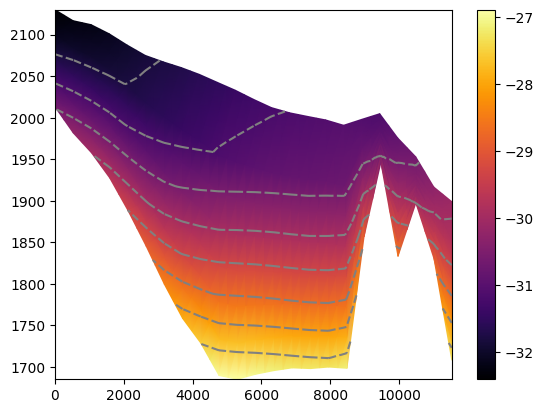

In [228]:
# Check final condition for accuracy
fig, ax = plt.subplots()
temp_field_end = firedrake.tripcolor(Ts[-1],cmap="inferno", axes=ax)
fig.colorbar(colors, label="Temperature (${}^\circ$C)")
levels = np.linspace(T.dat.data.min(), T.dat.data.max(), 10)
firedrake.tricontour(Ts[-1], levels=levels, colors="grey", axes=ax);
fig.colorbar(temp_field_end)

### Compare to borehole measurements

#### - Load the borehole location

In [229]:
borehole_locs = pd.read_csv("Borehole_locations_distance.csv")
borehole_loc = borehole_locs[borehole_locs['Borehole'] == 'ALHIC1902']

x_loc = borehole_loc["Borehole_Distance"].values[0]-200 #This was given wrong I think so hence the minus 1000
y_values = np.linspace(np.min(mesh.coordinates.dat.data[:,1]), np.max(mesh.coordinates.dat.data[:,1]), 50)

#### - Load the file with the real values

In [230]:
with open('borehole_temps/AH_borehole_temps_averaged.pickle', 'rb') as temps_f:
    real_temp_data = pkl.load(temps_f)

#### - Get model values

In [231]:
# Filter coordinates near x = x_target
coords = mesh.coordinates.dat.data_ro
tolerance = 200
y_values_at_x = [y for x, y in coords if abs(x - x_loc) < tolerance]

# Compute min and max y values
if y_values_at_x:
    y_min = min(y_values_at_x)
    y_max = max(y_values_at_x)
    print(f"At x = {x_loc}, y ranges from {y_min} to {y_max}")
else:
    print(f"No mesh points found at x = {x_loc} (within tolerance {tolerance})")
    
num_points = 20


x_vals = np.linspace(x_loc, x_loc, num_points)
y_vals = np.linspace(1800, y_max, num_points)

# Sample values along the line
temp_profile_values = np.array([Ts[-1].sub(0).at(x, y) for x, y in zip(x_vals, y_vals)])

At x = 8800.0, y ranges from 1856.650796796855 to 1998.005628827817


#### - Plot real temps (scale the height to match model)

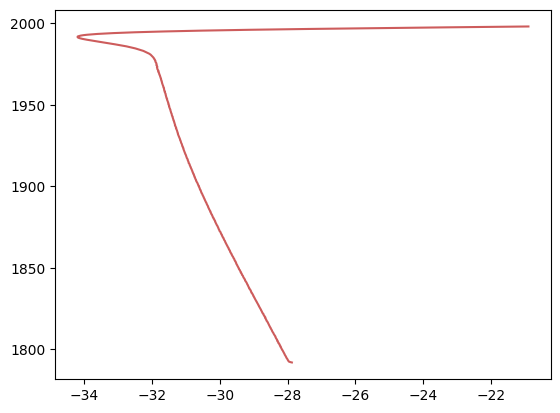

In [232]:
fig, ax = plt.subplots()

ax.plot(real_temp_data['ALHIC1902_23'][1], (real_temp_data['ALHIC1902_23'][0]-real_temp_data['ALHIC1902_23'][0][-1])[::-1]+y_vals[-1], label='Real Temp',c='indianred')

#### - Plot the model temps

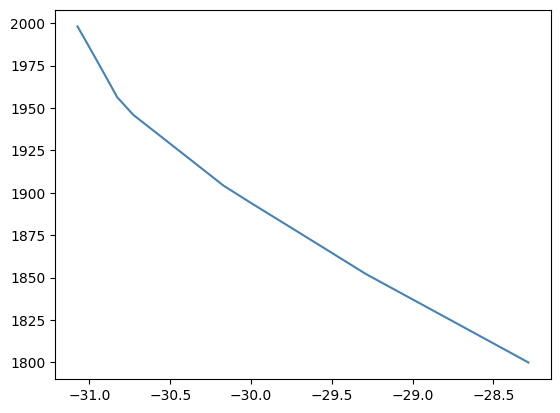

In [233]:
fig, ax = plt.subplots()

ax.plot(temp_profile_values, y_vals, label='Model Temp', c='steelblue')

#### - Plot the real and model temps together

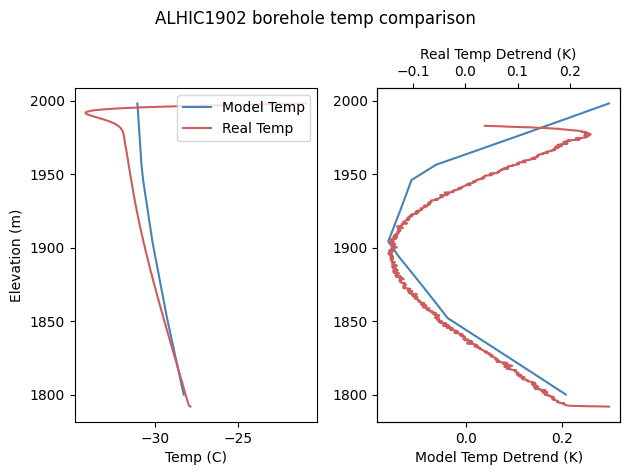

In [234]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(temp_profile_values, y_vals, label='Model Temp', c='steelblue')
ax2.plot(scipy.signal.detrend(temp_profile_values), y_vals, label='Model Temp', c='steelblue')

ax1.plot(real_temp_data['ALHIC1902_23'][1], (real_temp_data['ALHIC1902_23'][0]-real_temp_data['ALHIC1902_23'][0][-1])[::-1]+y_vals[-1], label='Real Temp',c='indianred')

ax3 = ax2.twiny()
ax3.plot(scipy.signal.detrend(real_temp_data['ALHIC1902_23'][1][60:]), (real_temp_data['ALHIC1902_23'][0]-real_temp_data['ALHIC1902_23'][0][-1])[::-1][60:]+y_vals[-1], label='Real Temp',c='indianred')

ax1.set_ylabel('Elevation (m)')
ax1.set_xlabel('Temp (C)')
ax2.set_xlabel('Model Temp Detrend (K)')
ax3.set_xlabel('Real Temp Detrend (K)')
fig.suptitle('ALHIC1902 borehole temp comparison')
ax1.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('ALHIC1902_borehole_temp_comparison.png')